# Knowledge Informed Machine Learning using a Weibull-based Loss Function
> Exploring the concept of knowledge-informed machine learning with the use of a Weibull-based loss function. Used to predict remaining useful life (RUL) on the [IMS](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#bearing) and [PRONOSTIA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#femto) (also called FEMTO) bearing data sets.

This notebook reproduces the results from the paper "Knowledge Informed Machine Learning using a Weibull-based Loss Function". The notebook also provides additional data exploration and explanation of the code used in the experiments.

**Note:** You can replicate the results without having to download the data in Section 2. The raw data is only needed for the data exploration.

If you have any questions, feel free to reach out or leave a question in the [discussions](https://github.com/tvhahn/weibull-knowledge-informed/discussions).

## Table of Contents
* [1. Setup Notebook](#1.-Setup-Notebook) - clone the repo and import require packages
* [2. Explore Data](#2.-Explore-Data) - download the raw data and see how it looks
* [3. Create Train/Val/Test Sets](#3.-Create-Train/Val/Test-Sets) - create the data splits (if you want) and visualize them
* [4. Train Models with a Random Search](#4.-Train-Models-with-a-Random-Search) - train the models
* [5. Summarize Results](#5.-Summarize-Results) - summarize the results of the random search to find the most effective loss functions

# 1. Setup Notebook
**For Google Colab:**
To run the notebook on google colab you must clone the repo an download the data

In [ ]:
!git clone https://github.com/tvhahn/weibull-knowledge-informed.git

# move into EarthGAN folder
%cd weibull-knowledge-informed

# make editable
!pip install -e .

Now we will create the train/val/test data sets used to train the models.

In [ ]:
# !python /content/weibull-knowledge-informed/src/data/make_dataset.py data/raw data/processed

And train some models as an example (we'll use the IMS data set).

In [ ]:
# !python /content/weibull-knowledge-informed/src/models/train_models.py \
# --data_set ims \
# --path_data data/processed \
# --proj_dir /content/weibull-knowledge-informed/

**Import Packages:**
Don't skip this step! Needed for Google Colab and if run locally.

In [7]:
import numpy as np
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, fftpack
import time
import datetime
import h5py

from src.features.build_features import (
    create_fft, 
    build_spectrogram_df_ims, 
    build_spectrogram_df_femto
)

from src.visualization.visualize_data import (
    create_time_frequency_plot, 
    plot_freq_peaks, 
    plot_spectogram_with_binned, 
    ims_data_processed_fig, 
    femto_data_processed_fig,
)

from src.visualization.visualize_results import (
    loss_function_percentage_fig,
    early_stop_distribution_fig,
    loss_function_correlation_fig,
    femto_results_rul_fig,
    ims_results_rul_fig,
)

from src.data.data_utils import (
    create_date_dict, 
    load_train_test_ims, 
    load_train_test_femto
)

from IPython.display import clear_output, display, Image # clear the output if needed
import warnings
warnings.filterwarnings("ignore") # supress all the matplotlib deprecation warnings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# set the root (parent folder) and the data folder locations
path_colab = Path.cwd().parent.parent / 'content'

if path_colab.exists():
    folder_root = Path.cwd() # get root folder of repository - use if on colab
else:
    folder_root = Path.cwd().parent # on local machine in ./notebooks folder

print(folder_root) 

/home/tim/Documents/weibull-knowledge-informed


# 2. Explore Data
Let's explore the data!

Start by downloading the IMS and PRONOSTIA (FEMTO) bearing data sets from the NASA Prognostics Repository.

In [ ]:
!bash /content/weibull-knowledge-informed/src/data/download_data_local.sh /content/weibull-knowledge-informed

Extract the downloaded data. (note: will take several minutes to extract)

In [ ]:
!bash /content/weibull-knowledge-informed/src/data/extract_data_local.sh /content/weibull-knowledge-informed

Look at some of the IMS data.

In [10]:
folder_raw_data = folder_root / 'data/raw/IMS/' # raw data folder

# load text file for first measurement
# first test folder location
folder_1st = folder_raw_data / '1st_test'

# can use numpy...
d = np.loadtxt(folder_1st / '2003.10.22.12.06.24')

# let's use pandas
    # b1_ch1 - Bearing 1, channel 1
    # b1_ch2 - Bearing 1, channel 2
    # etc, etc ...

col_names = ['b1_ch1', 'b1_ch2', 'b2_ch3', 'b2_ch4', 'b3_ch5', 'b3_ch6', 'b4_ch7', 'b4_ch8']
df = pd.read_csv(folder_1st / '2003.10.22.12.06.24', sep='\t', names=col_names)
df.head()

b1_ch1  b1_ch2  b2_ch3  b2_ch4  b3_ch5  b3_ch6  b4_ch7  b4_ch8
0  -0.022  -0.039  -0.183  -0.054  -0.105  -0.134  -0.129  -0.142
1  -0.105  -0.017  -0.164  -0.183  -0.049   0.029  -0.115  -0.122
2  -0.183  -0.098  -0.195  -0.125  -0.005  -0.007  -0.171  -0.071
3  -0.178  -0.161  -0.159  -0.178  -0.100  -0.115  -0.112  -0.078
4  -0.208  -0.129  -0.261  -0.098  -0.151  -0.205  -0.063  -0.066

In [11]:
# what is the shape of the dataframe?
df.shape

(20480, 8)

Gousseau et al. postulate in their paper ['Analysis of the Rolling Element Bearing data set of the Center for Intelligent Maintenance Systems of theUniversity of Cincinnati'](https://hal.archives-ouvertes.fr/hal-01715193) that the actual collection frequency is 20.48 kHz.

We will use this collection frequency.

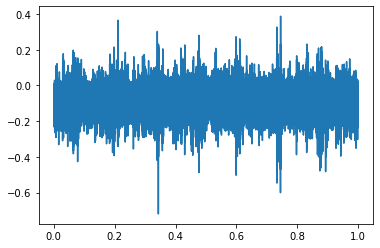

In [12]:
# plot first bearing channel
fig, ax = plt.subplots()

ax.plot(
    np.arange(0,df.shape[0], dtype='float64') / (20.48 * 10**3), # make x-axis in seconds
    df['b1_ch1'] # acceleration data
)

We will want to "detrend" and window the signal -- this is a basic signal processing step.

In [23]:
# practice detrending
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['b1_ch1'], alpha=0.5, label='original signal')
y_detrend = signal.detrend(df['b1_ch1'], type="linear")
plt.plot(y_detrend, alpha=0.5, label='detrended signal')

# apply either a hamming or kaiser windowing function
# y_detrend *= np.hamming(len(y_detrend))
y_detrend *= np.kaiser(len(y_detrend), 3)
plt.plot(y_detrend, alpha=0.5, label='windowed signal')
plt.legend(loc='center left')

Use a function to create the FFT (`create_fft`), and another function to plot the time and frequency domains (`create_time_frequency_plot`).

In [24]:
# create fft
x, y, xf, yf = create_fft(df, y_name='b1_ch2', sample_freq=20480.0, window='kaiser', beta=3)

# plot
create_time_frequency_plot(x, y, xf, yf, save_plot=False)

It is interesting to look at the peaks in the frequency domain plot, since different peaks can correspond to different parts of the bearing.example.ipynb

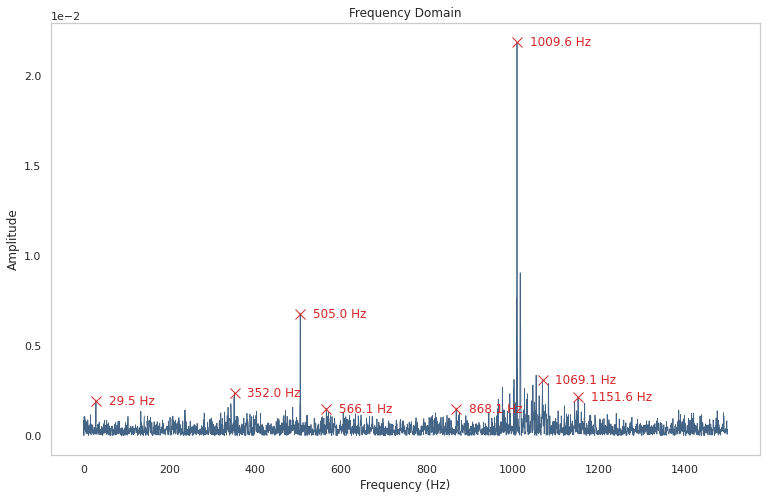

In [8]:
# only plot to 1500 Hz
plot_freq_peaks(xf, yf, max_freq_to_plot=1500, peak_height=0.0015, peak_distance=50)

## 2.1 Build Spectrograms - IMS
We will create a spectrogram of each run. A spectrogram is merely a "stack" of FFTs over time.

We have created a function, `build_spectrogram_df_ims`, that creates the spectrogram.

In [6]:
folder_1st = folder_raw_data / "1st_test"

date_list = sorted(os.listdir(folder_1st))

col_names = [
    "b1_ch1",
    "b1_ch2",
    "b2_ch3",
    "b2_ch4",
    "b3_ch5",
    "b3_ch6",
    "b4_ch7",
    "b4_ch8",
]

df_spec, labels_dict = build_spectrogram_df_ims(
    folder_1st,
    date_list,
    channel_name="b3_ch5",
    start_time=date_list[0],
    col_names=col_names,
)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

The output from the `build_spectrogram_df_ims` is a dataframe of the spectrogram, and a dictionary of the times when the signals were collected. Here's what the dataframe looks like:

In [11]:
df_spec.head()

2003-10-22 12:06:24  2003-10-22 12:09:13  2003-10-22 12:14:13  \
0.000000             0.000376             0.000613             0.000252   
0.500049             0.000945             0.001218             0.000698   
1.000098             0.000063             0.000332             0.000939   
1.500146             0.000576             0.000218             0.000920   
2.000195             0.001071             0.000454             0.000430   

          2003-10-22 12:19:13  2003-10-22 12:24:13  2003-10-22 12:29:13  \
0.000000             0.000441             0.000521             0.000036   
0.500049             0.000682             0.000989             0.000282   
1.000098             0.000389             0.000121             0.000352   
1.500146             0.000175             0.000368             0.000339   
2.000195             0.000346             0.001266             0.000625   

          2003-10-22 12:34:13  2003-10-22 12:39:13  2003-10-22 12:44:13  \
0.000000             0.000209             0.000456             0.000166   
0.500049             0.000364             0.000892             0.000415   
1.000098             0.000437             0.000919             0.001642   
1.500146             0.000217             0.000456             0.000262   
2.000195             0.000926             0.000582             0.000379   

          2003-10-22 12:49:13  ...  2003-11-25 15:17:32  2003-11-25 15:27:32  \
0.000000             0.000390  ...             0.000330             0.000165   
0.500049             0.000716  ...             0.000763             0.000441   
1.000098             0.000924  ...             0.001127             0.001378   
1.500146             0.000114  ...             0.001530             0.001394   
2.000195             0.000170  ...             0.000098             0.003607   

          2003-11-25 15:37:32  2003-11-25 15:47:32  2003-11-25 15:57:32  \
0.000000             0.000045             0.000075             0.000470   
0.500049             0.000975             0.000540             0.000395   
1.000098             0.001142             0.000337             0.001335   
1.500146             0.002433             0.002552             0.001853   
2.000195             0.000065             0.001958             0.001119   

          2003-11-25 16:07:32  2003-11-25 23:13:21  2003-11-25 23:19:56  \
0.000000             0.000686             0.001904             0.001696   
0.500049             0.001483             0.002665             0.003242   
1.000098             0.000386             0.001652             0.004217   
1.500146             0.001799             0.001231             0.001667   
2.000195             0.001281             0.003249             0.000946   

          2003-11-25 23:29:56  2003-11-25 23:39:56  
0.000000             0.000245             0.065340  
0.500049             0.000473             0.129645  
1.000098             0.000916             0.141756  
1.500146             0.000590             0.062438  
2.000195             0.001417             0.096466  

[5 rows x 2156 columns]

Here is a value from the `labels_dict`, generated from the above function. Each key in the dictionary represents a list that holds five time values/formats.

* Date with a nice format, like `2003-10-22 12:34:13`
* Date with underscores, like `2003_10_22_12_34_13` - this is also the key for this dictionary item.
* Unix timestamp, like `1066851253.0`
* Time increment since start of run (in seconds), like `1669.0`
* Time increment since start of run (in days), like `0.01931712962962963`

In [12]:
labels_dict['2003_10_22_12_34_13']

['2003-10-22 12:34:13',
 '2003_10_22_12_34_13',
 1066851253.0,
 1669.0,
 0.01931712962962963]

Let's plot the spectrogram.

The spectrogram is fairly "dim" unless you add a "vmax" value. This is partly because the 1000 Hz peak is dominating the FFT.

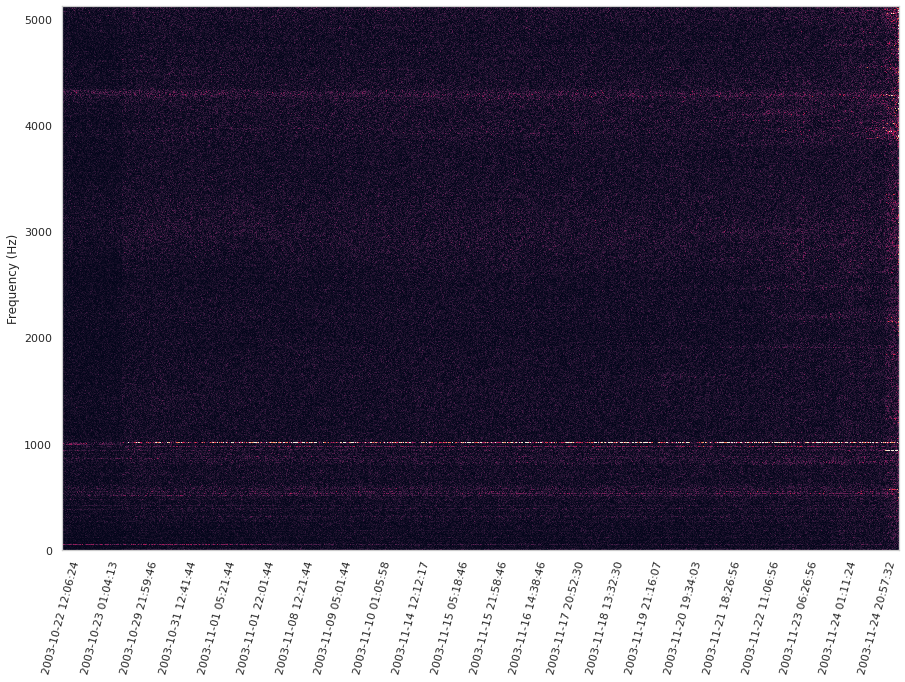

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.01) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

Try some other runs for the IMS data set and see what the spectrogram looks like!

In [14]:
folder_2nd = folder_raw_data / '2nd_test'
date_list = sorted(os.listdir(folder_2nd))
col_names = ['b1_ch1', 'b2_ch2', 'b3_ch3', 'b4_ch4']
df_spec, labels_dict = build_spectrogram_df_ims(folder_2nd, date_list, channel_name='b1_ch1', start_time=date_list[0], col_names=col_names)

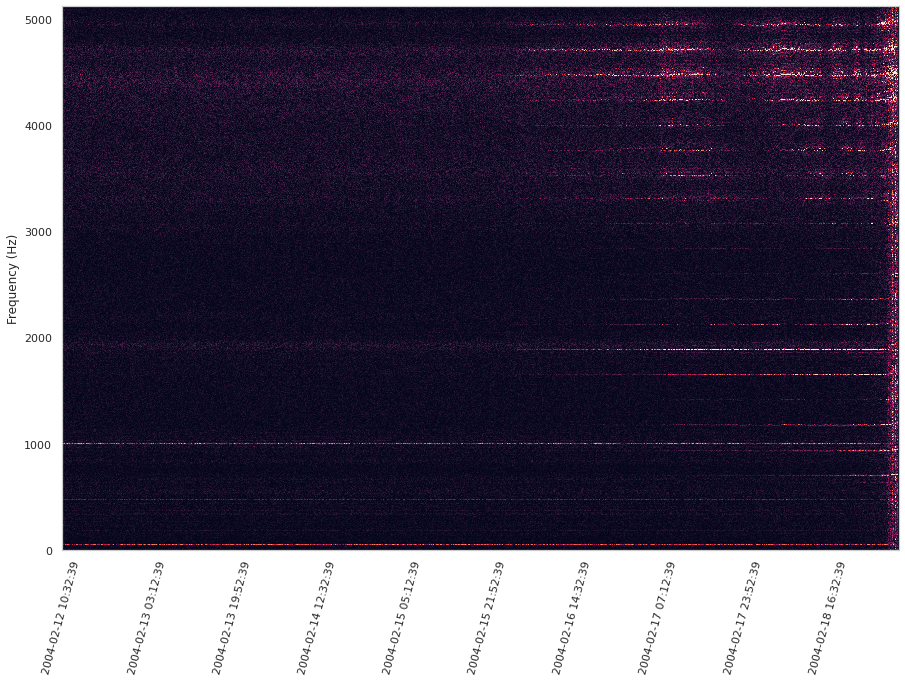

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.01) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

Inspect the `dataset_ims.py` (GitHub link [here](https://github.com/tvhahn/weibull-knowledge-informed/blob/master/src/data/dataset_ims.py)) to see how we create spectrograms for each of the three runs in the IMS data set.

We do not train our neural network on the entire spectrogram, or on each individual FFT. Rather, we segment the spectrogram into 20 buckets. Each time step, with 10 bins, is an input into the model we will be training.

Here's a grapic of what the above spectrogram looks like after this "binning".

(10000, 984)


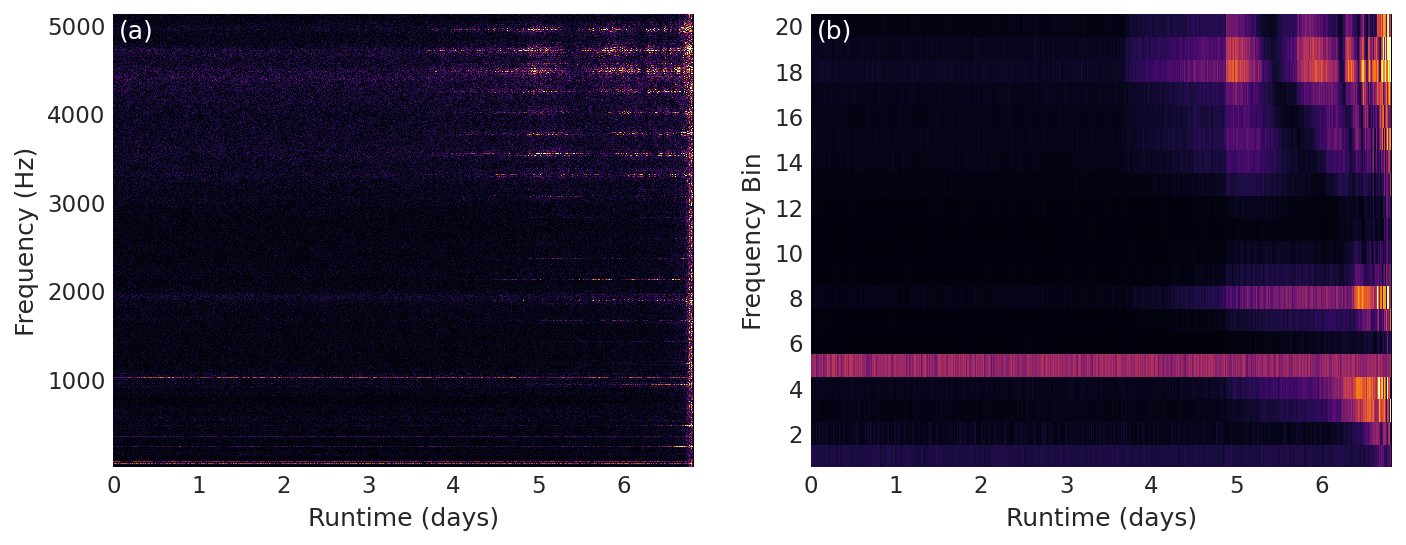

In [16]:
plot_spectogram_with_binned(
    df_spec,
    labels_dict,
    vmax_factor1=0.08,
    vmax_factor2=0.5,
    save_plot=False,
)

## 2.2 Build Spectrograms - PRONOSTIA
Similarly, we can build spectrograms for the runs in the PRONOSTIA (FEMTO) bearing data set. Inspect the `dataset_femto.py` (GitHub link [here](https://github.com/tvhahn/weibull-knowledge-informed/blob/master/src/data/dataset_femto.py)) to see how we've created spectrograms for the runs in the data set.

In [17]:
folder_raw_data_train = (folder_root / 'data/raw' / "FEMTO/Learning_set/") 

folder_indv_bearing = folder_raw_data_train / "Bearing1_1"
date_dict = create_date_dict(folder_indv_bearing)
df_spec, labels_dict = build_spectrogram_df_femto(folder_indv_bearing, date_dict, channel_name="acc_horz",)

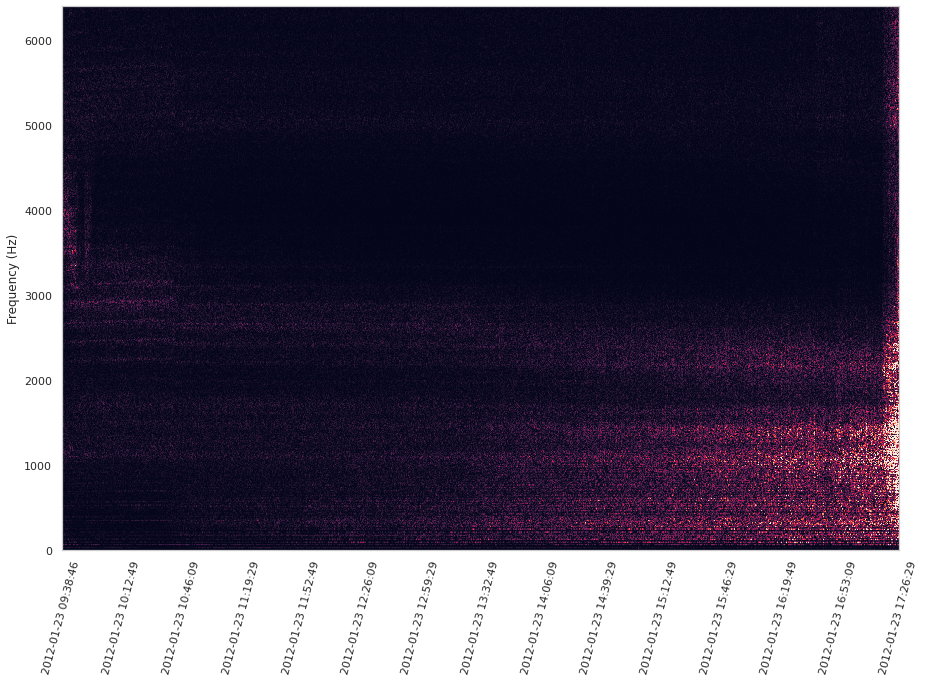

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.2) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::200]) # show every 200th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

# 3. Create Train/Val/Test Sets
This script will create the training, validation and testing data sets. Note: the data sets are included in the repo, so you don't need to run this step for this notebook.

In [ ]:
!python /content/weibull-knowledge-informed/src/data/make_dataset.py data/raw data/processed

We have two functions that load the data sets -- `load_train_test_ims` for the IMS data sets, and `load_train_test_femto` for the PRONOSTIA data set.

Let's start by looking at the IMS data.

In [23]:
folder_data = folder_root / "data/processed/IMS/"

(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    x_train_2,
    y_train_2,
    x_train_3,
    y_train_3,
) = load_train_test_ims(folder_data)

In [25]:
print("x_train.shape,", x_train.shape)
print("y_train.shape,", y_train.shape)

x_train.shape, torch.Size([7304, 20])
y_train.shape, torch.Size([7304, 3])


As you can see, the individual data splits are saved as PyTorch tensors.

`y_train` has the following makeup:

In [26]:
y_train

tensor([[3.4531e+01, 7.7289e-01, 1.0147e+01],
        [1.8996e+01, 4.2518e-01, 2.5681e+01],
        [5.4583e+00, 7.9959e-01, 1.3681e+00],
        ...,
        [1.7812e+00, 3.9869e-02, 4.2896e+01],
        [1.5989e+01, 3.5788e-01, 2.8688e+01],
        [6.0903e+00, 8.9217e-01, 7.3611e-01]])

The second dimension in `y_train` is made up of three columns:

* Column 1: Run time since start (in days)
* Column 2: Percentage life remaining
* Column 3: Remaining useful life (in days)

We can now visualize the prepared data using the `ims_data_processed_fig` function.

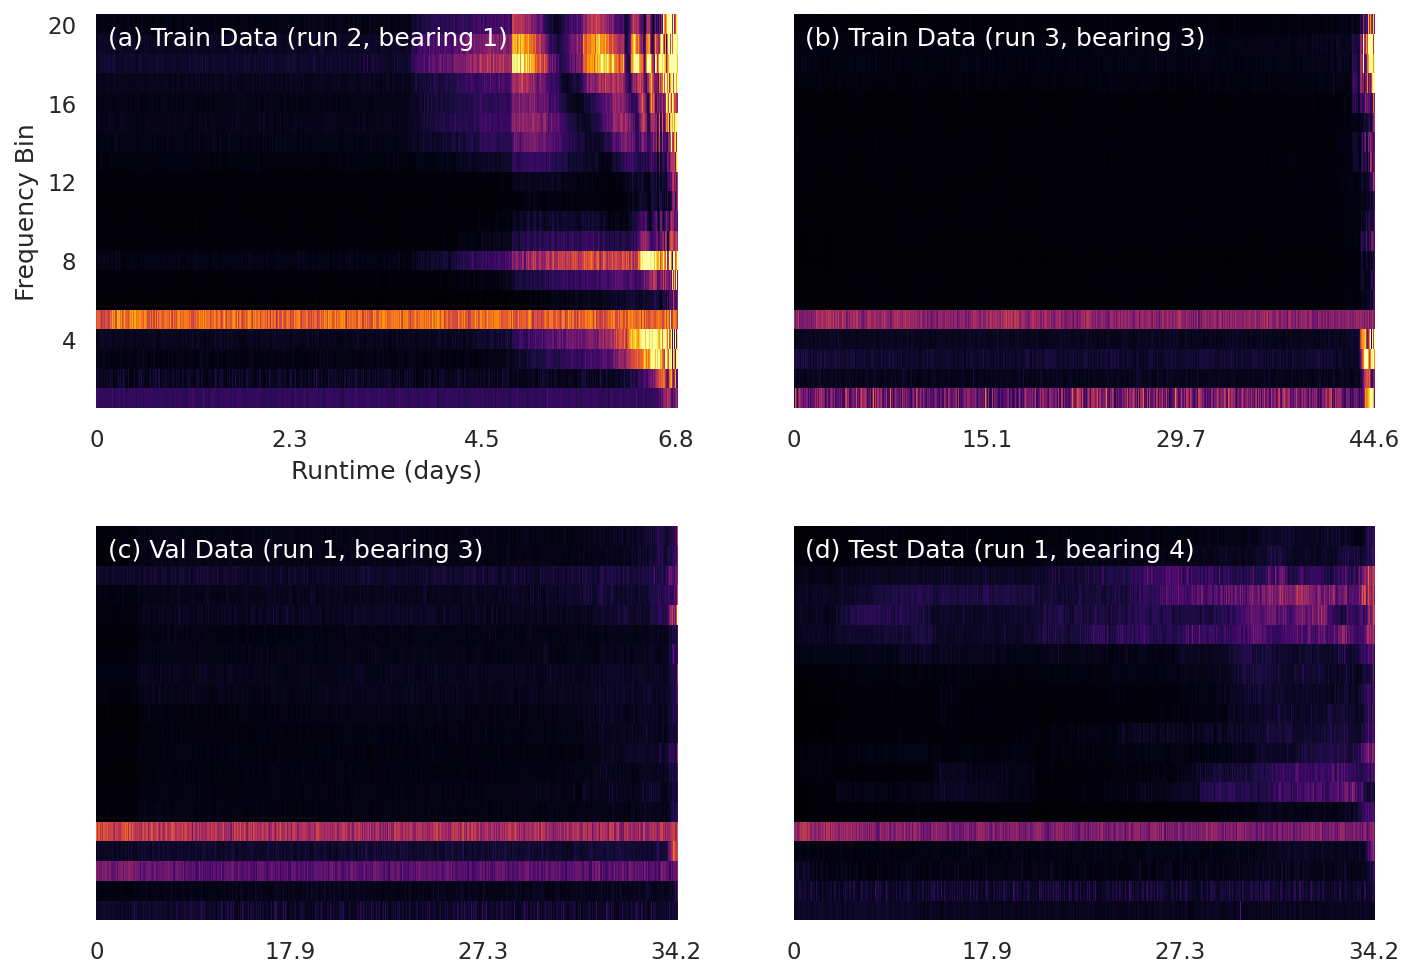

In [33]:
ims_data_processed_fig(
    folder_data,
    dpi=150,
    save_plot=False
)

Now let's look at the PRONOSTIA data.

You'll see that there are many more runs in the PRONOSTIA (FEMTO) data set, and we don't even use them all.

In [37]:
folder_data = folder_root / "data/processed/FEMTO/"

(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    x_train1_1,
    y_train1_1,
    x_train2_1,
    y_train2_1,
    x_train3_1,
    y_train3_1,
    x_val1_2,
    y_val1_2,
    x_val2_2,
    y_val2_2,
    x_val3_2,
    y_val3_2,
    x_test1_3,
    y_test1_3,
    x_test2_3,
    y_test2_3,
    x_test3_3,
    y_test3_3,
) = load_train_test_femto(folder_data)

print("x_train.shape,", x_train.shape)
print("y_train.shape,", y_train.shape)

x_train.shape, torch.Size([4222, 20])
y_train.shape, torch.Size([4222, 3])


Again, let's visualize the various cuts using the `femto_data_processed_fig` function.

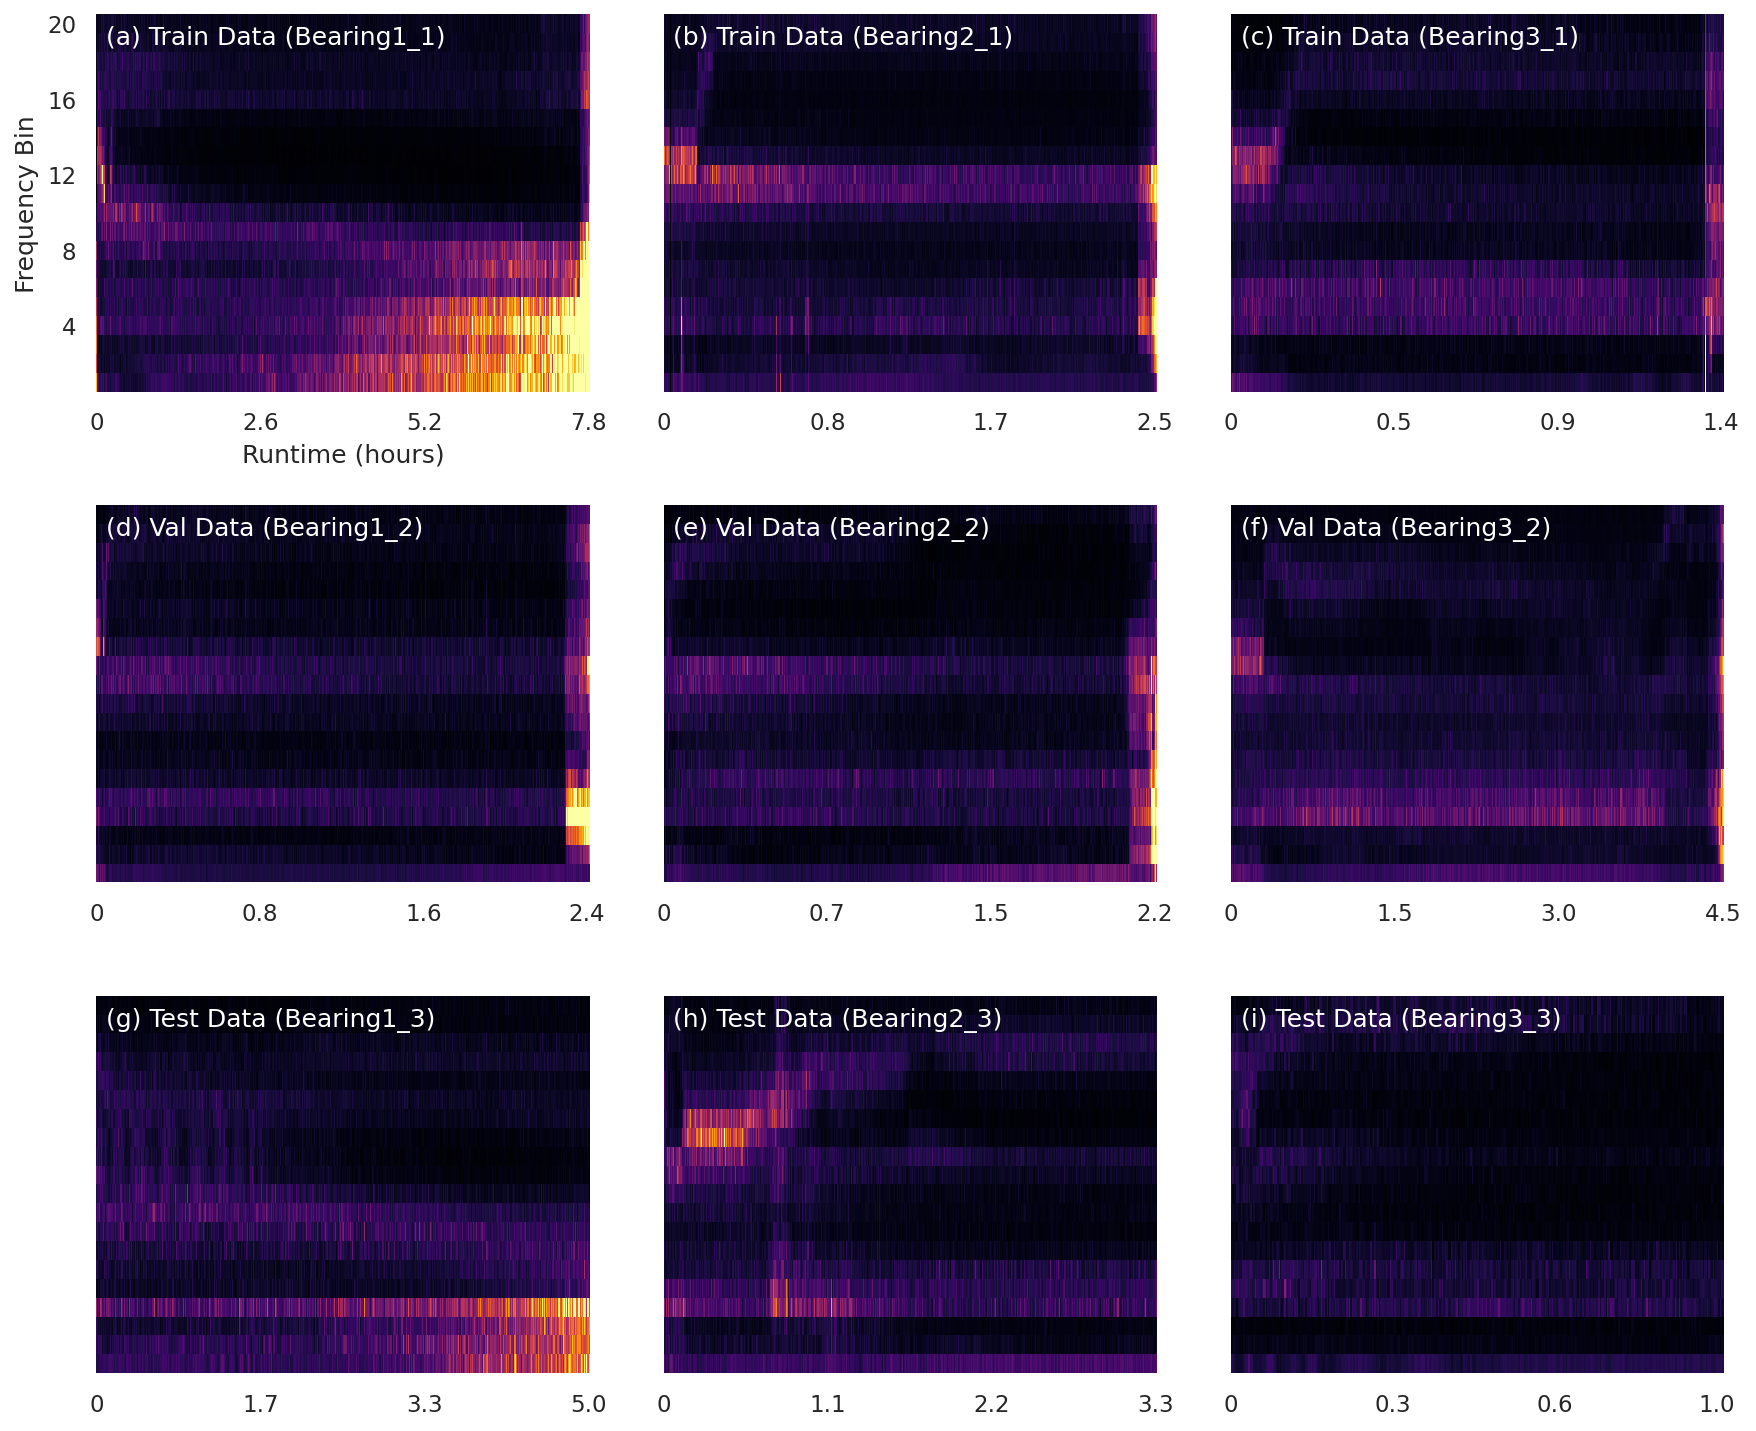

In [39]:
femto_data_processed_fig(
    folder_data,
    dpi=150,
    vmax_val=0.15,
    save_plot=False
)

# 4. Train Models with a Random Search
We can perform a random search across a wide variety of feed forward neural networks by calling on the `train_models.py` script.

Here's an example of what one of the models that we'll train could look like:

<br>
<div style="text-align: center; ">
<figure>
  <img src="../reports/figures/model_example.svg" alt="neural network example" style="background:none; border:none; box-shadow:none; text-align:center" width="800px"/>
  <div style="text-align: center; ">
  <br>
  <figcaption style="color:grey; font-size:smaller">Many simple feed-forward neural networks are used in the random search.</figcaption>
  </div>
</figure>
</div>

Let's perform a small random search -- two random search iterations.

In [56]:
!python /content/weibull-knowledge-informed/src/models/train_models.py \
--data_set ims \
--path_data data/processed \
--proj_dir /content/weibull-knowledge-informed/ \
--random_search_iter 2

python: can't open file '/content/weibull-knowledge-informed/src/models/train_models.py': [Errno 2] No such file or directory


The results are saved in the `models` folder. The parameters, and performance, of each model in the random search is saved in a csv in the `models/interim/results_csv_ims` or `models/interim/results_csv_femto` folder. Let's take a look at one of these csvs.

In [ ]:
folder_results_csv = folder_root / 'models/interim/results_csv_ims'

# get a list of all file names in folder_results_csv
files = os.listdir(folder_results_csv)
file_list = [folder_results_csv / filename for filename in files if filename.endswith('.csv')]

# print the path of the first csv in file_list
print(file_list[0])

df = pd.read_csv(file_list[0])
df.head()

In the above dataframe, you'll note that there are no test results. This is so that we do not go about "fishing" for a good result. Only until we've trained all the models can we check the performance of the models so as to not bias our results.

Each model trained during the random search also has an associated learning curve created for it. This way you can see how the model trained -- to make sure the training makes sense.

Let's load one of these learning curves.

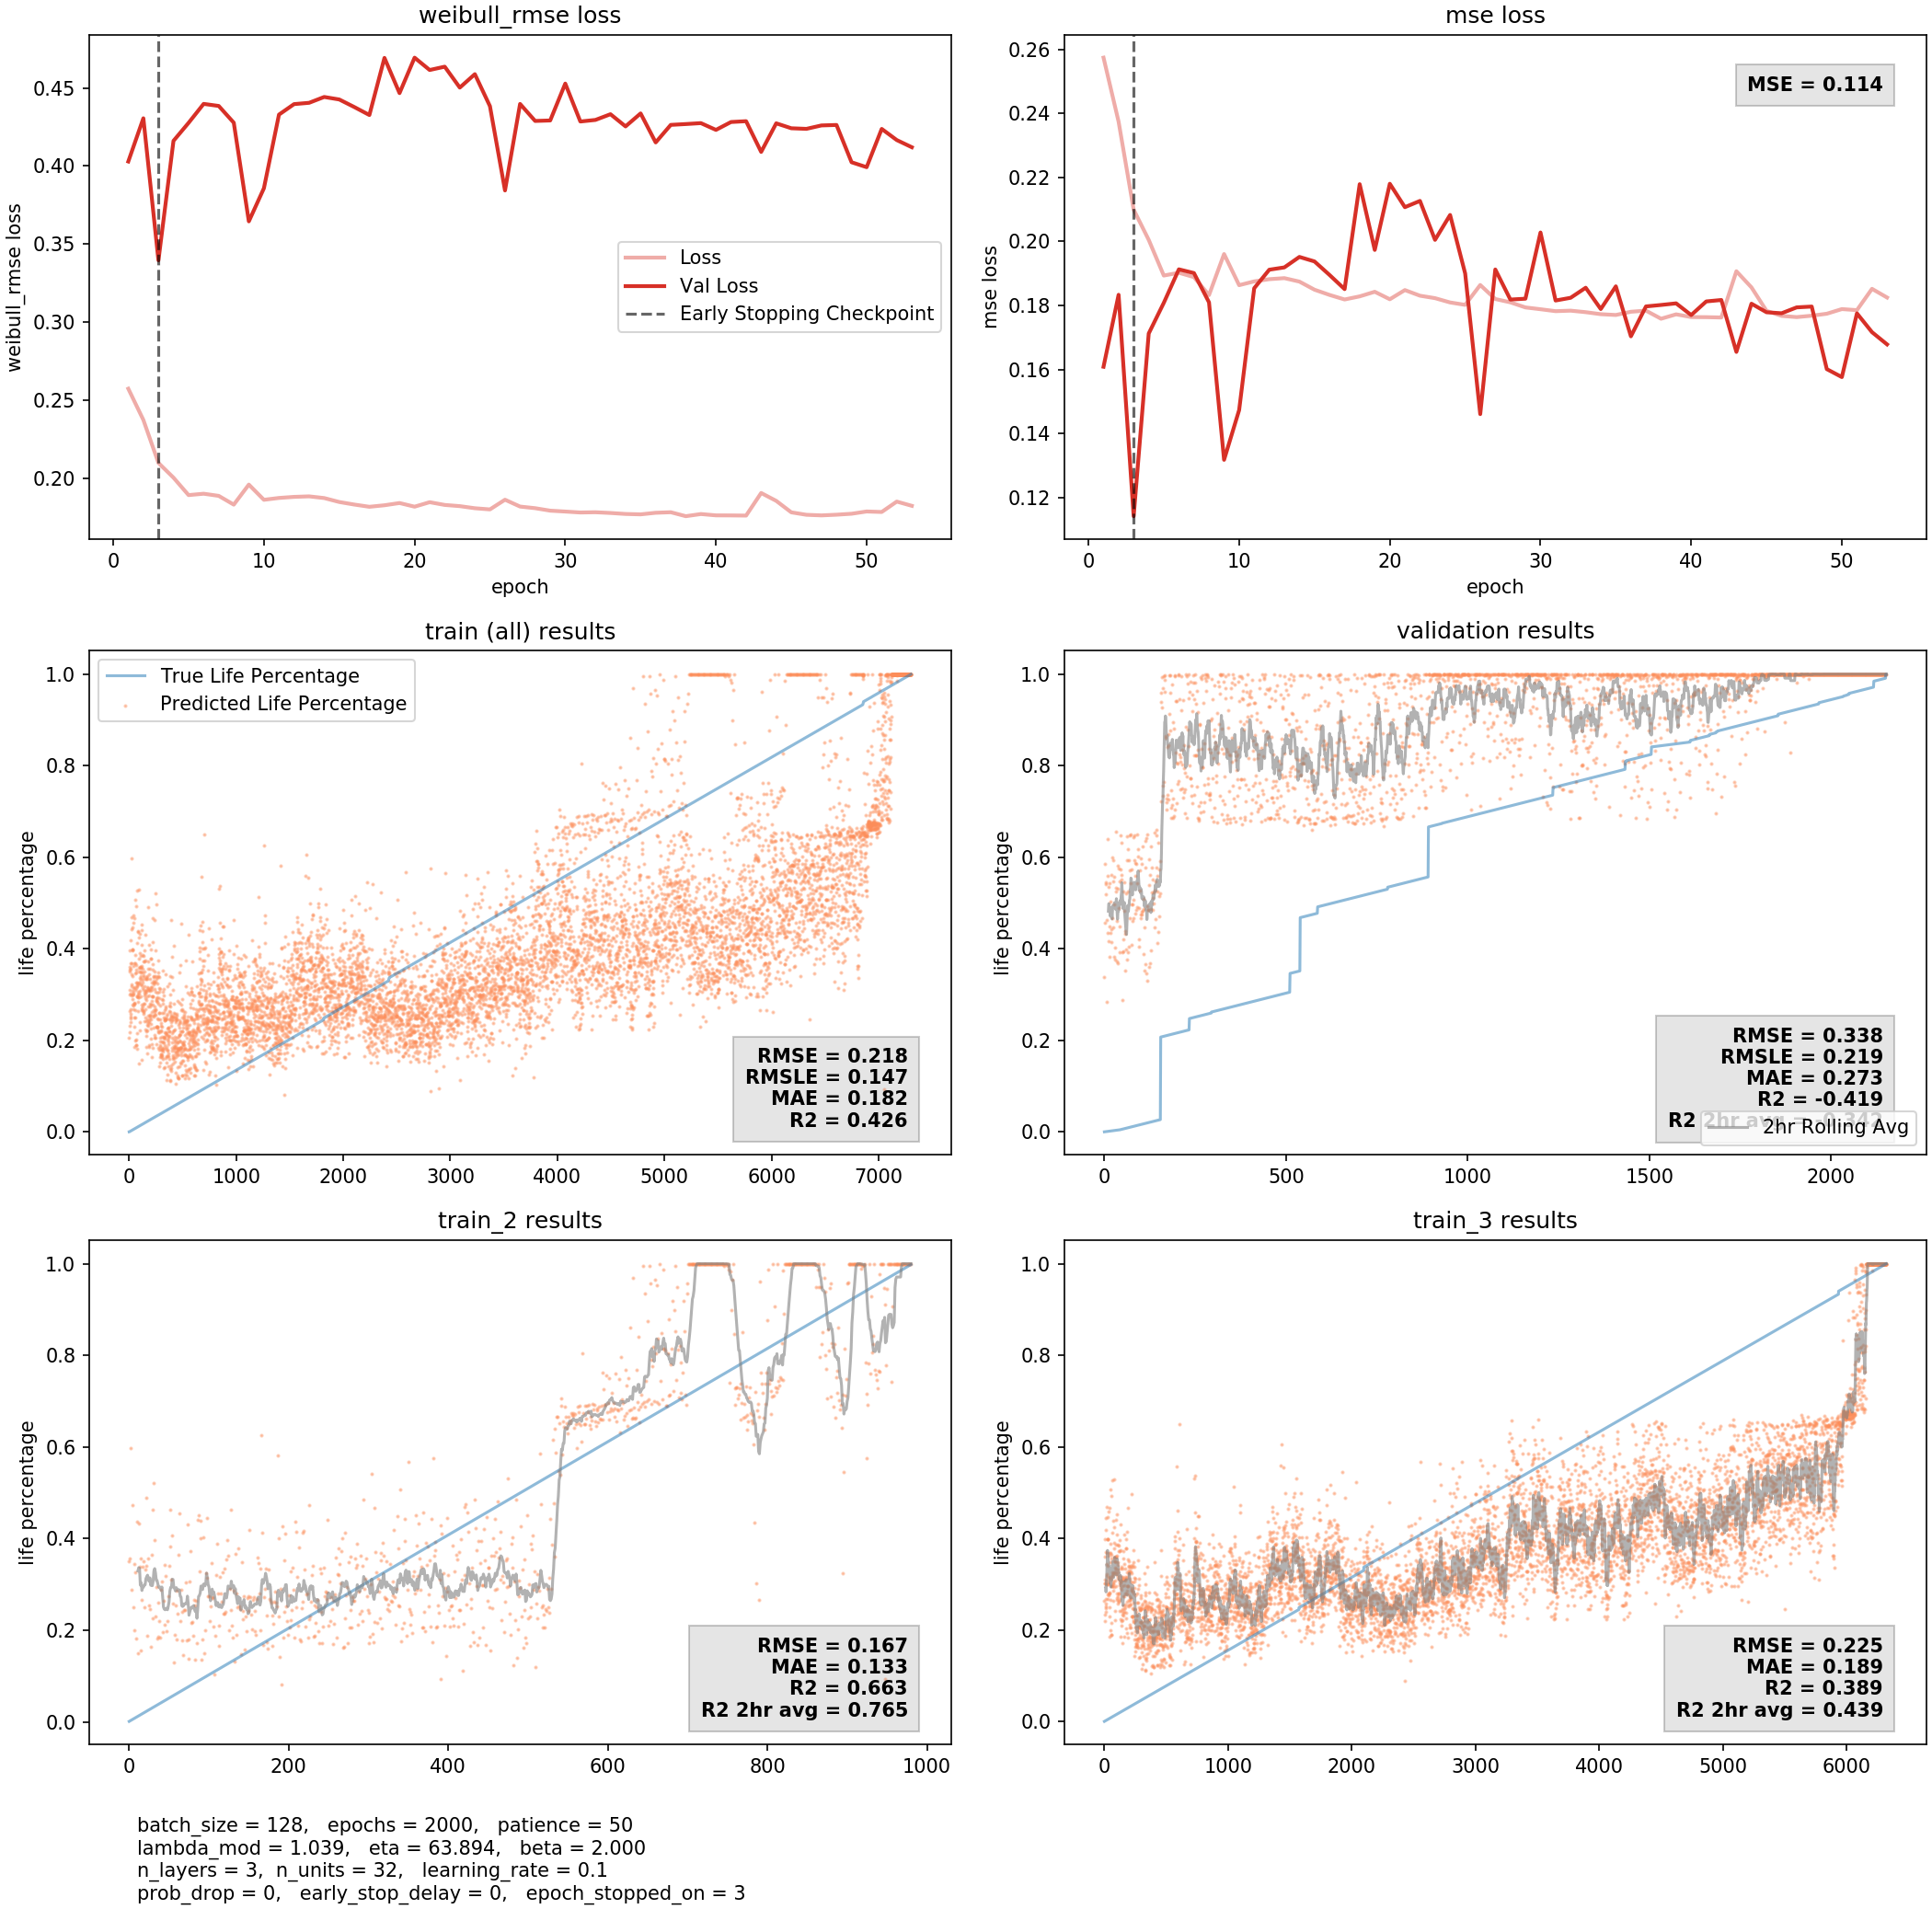

In [7]:
folder_results_curve = folder_root / 'models/interim/learning_curves_ims'

files = os.listdir(folder_results_curve)
file_list = [folder_results_curve / filename for filename in files if filename.endswith('.png')]


Image(filename=str(file_list[1]), width=900) # use from IPython.display import Image

# 5. Summarize Results
All the models from the random search have been trained. Now we need to find the best performing models and filter out the poorly performing ones.

The `summarize_model_results.py` script will take all the trained models (and the result csvs) and summarize the results into a number of consolidated csvs. These results will then be used to produce some nice charts.

* `{femto or ims}_correlation_results.csv` - the correlation between loss functions and the test $R^2$ for models passing the filter criteria
* `{femto or ims}_count_results.csv` - the count of the types of loss functions from models passing the filter criteria
* `{femto or ims}_early_stop_summary_stats.csv` - count of the early stop times for models
* `{femto or ims}_results_filtered.csv` - the results table after filtering, with all columns
* `{femto or ims}_results_summary_all.csv.gz` - the results table before filtering, with all columns

You can run the `summarize_model_results.py` below (uncomment the cell), but you may not have enough models trained to get passed the filtering criteria. Because of that, we'll load the `ims_results_summary_all.csv.gz` as a demonstration to see how the filtering was carried out.

In [8]:
# !python /content/weibull-knowledge-informed/src/models/summarize_model_results.py --data_set ims
# !python /content/weibull-knowledge-informed/src/models/summarize_model_results.py --data_set femto

Load the `ims_results_summary_all.csv.gz`.

In [9]:
csv_results_all = folder_root / 'models/final' / 'ims_results_summary_all.csv.gz'

df = pd.read_csv(csv_results_all, compression='gzip',)
df.head()

date_time data_set     loss_func  rnd_seed_input  \
0  2021_04_05_12:13:49      ims           mse         2031227   
1  2021_04_05_12:13:49      ims          rmse         2031227   
2  2021_04_05_12:13:49      ims         rmsle         2031227   
3  2021_04_05_12:13:49      ims   weibull_mse         2031227   
4  2021_04_05_12:13:49      ims  weibull_rmse         2031227   

   rnd_search_iter  rnd_search_iter_no  beta        eta  epochs  patience  \
0             3000                   0   2.0  63.893981    2000        50   
1             3000                   0   2.0  63.893981    2000        50   
2             3000                   0   2.0  63.893981    2000        50   
3             3000                   0   2.0  63.893981    2000        50   
4             3000                   0   2.0  63.893981    2000        50   

   ...  prob_drop_true  mse  rmse  rmsle  weibull_mse  weibull_rmse  \
0  ...               1    1     0      0            0             0   
1  ...               1    0     1      0            0             0   
2  ...               1    0     0      1            0             0   
3  ...               1    0     0      0            1             0   
4  ...               1    0     0      0            0             1   

   weibull_rmsle  weibull_only_mse  weibull_only_rmse  weibull_only_rmsle  
0              0                 0                  0                   0  
1              0                 0                  0                   0  
2              0                 0                  0                   0  
3              0                 0                  0                   0  
4              0                 0                  0                   0  

[5 rows x 49 columns]

There is a lot going on in the `df` results dataframe. Here are all the column names:

In [10]:
df.columns

Index(['date_time', 'data_set', 'loss_func', 'rnd_seed_input',
       'rnd_search_iter', 'rnd_search_iter_no', 'beta', 'eta', 'epochs',
       'patience', 'early_stop_delay', 'batch_size', 'learning_rate',
       'lambda_mod', 'n_layers', 'n_units', 'prob_drop', 'epoch_stopped_on',
       'loss_mse_train', 'loss_rmse_train', 'loss_mae_train',
       'loss_rmsle_train', 'r2_train', 'loss_mse_val', 'loss_rmse_val',
       'loss_mae_val', 'loss_rmsle_val', 'r2_val', 'r2_val_avg',
       'r2_train_2_avg', 'r2_train_3_avg', 'date_time_seed',
       'model_checkpoint_name', 'r2_test', 'r2_test_avg', 'loss_mae_test',
       'loss_rmse_test', 'loss_rmsle_test', 'weibull_loss', 'prob_drop_true',
       'mse', 'rmse', 'rmsle', 'weibull_mse', 'weibull_rmse', 'weibull_rmsle',
       'weibull_only_mse', 'weibull_only_rmse', 'weibull_only_rmsle'],
      dtype='object')

How many unique model architectures?

In [11]:
print("No. unique model architectures:", len(df["date_time_seed"].unique()))
print("No. unique models (includes unique loss functions):", len(df["date_time_seed"]))

No. unique model architectures: 1078
No. unique models (includes unique loss functions): 9377


## 5.1 Example of Filtering Out Poorly Performing Models
We performed a large random search. Naturally, many of the models will be of low quality. To filter out the low quality models we will establish a threshold criteria -- models above the threshold we'll keep, and models below will be removed from further analysis.

There are a number of way to filter out poorly performing models. We've chosen to use $R^2$ and RMSE, and we will sort the results by the test $R^2$.

In [12]:
# Filter parameters
R2_BOUND = 0.2  # greater than
RMSE_BOUND = 0.35  # less than
SORT_BY = "r2_test"  # metric used to evaluate results

In [13]:
# filter results and select top models
loss_func_list = df["loss_func"].unique()

sort_by = SORT_BY

dfr = df[
    (df["r2_test"] > R2_BOUND)
    & (df["loss_rmse_test"] < RMSE_BOUND)
    & (df["r2_train"] > R2_BOUND)
    & (df["loss_rmse_train"] < RMSE_BOUND)
    & (df["r2_val"] > R2_BOUND)
    & (df["loss_rmse_val"] < RMSE_BOUND)
    & (df["beta"] == 2.0)
][:]

dfr = (
    dfr.groupby(["date_time_seed"])
    .apply(lambda x: x.sort_values([sort_by], ascending=False))
    .reset_index(drop=True)
)

dfr = (dfr.groupby(["date_time_seed"]).head(1).sort_values(by=sort_by, ascending=False))

In [14]:
dfr.head()

date_time data_set      loss_func  rnd_seed_input  \
3478  2021_04_05_17:06:26      ims   weibull_rmse         3405377   
3671  2021_04_05_17:28:24      ims  weibull_rmsle         6474908   
331   2021_04_05_13:09:38      ims  weibull_rmsle         8095234   
3619  2021_04_05_17:20:33      ims  weibull_rmsle         3860637   
3047  2021_04_05_16:20:38      ims          rmsle         5826015   

      rnd_search_iter  rnd_search_iter_no  beta        eta  epochs  patience  \
3478             3000                  14   2.0  63.893981    2000        50   
3671             3000                  13   2.0  63.893981    2000        50   
331              3000                  13   2.0  63.893981    2000        50   
3619             3000                   6   2.0  63.893981    2000        50   
3047             3000                   6   2.0  63.893981    2000        50   

      ...  prob_drop_true  mse  rmse  rmsle  weibull_mse  weibull_rmse  \
3478  ...               0    0     0      0            0             1   
3671  ...               0    0     0      0            0             0   
331   ...               1    0     0      0            0             0   
3619  ...               1    0     0      0            0             0   
3047  ...               0    0     0      1            0             0   

      weibull_rmsle  weibull_only_mse  weibull_only_rmse  weibull_only_rmsle  
3478              0                 0                  0                   0  
3671              1                 0                  0                   0  
331               1                 0                  0                   0  
3619              1                 0                  0                   0  
3047              0                 0                  0                   0  

[5 rows x 49 columns]

In [15]:
print("No. unique model architectures:", len(dfr["date_time"].unique()))
print("No. unique models (includes unique loss functions):", len(dfr["date_time"]))

No. unique model architectures: 727
No. unique models (includes unique loss functions): 775


You can inspect the `summarize_model_results.py` to see how the rest of the result tables are created.

## 5.2 Visualize Results
With all the results tables created (and saved as csvs), we can visualize some results.

In [13]:
# csv result locations
path_results = folder_root / "models/final/"
path_save_loc = folder_root / "reports/figures/"


In [17]:
from src.visualization.visualize_results import loss_function_percentage_fig

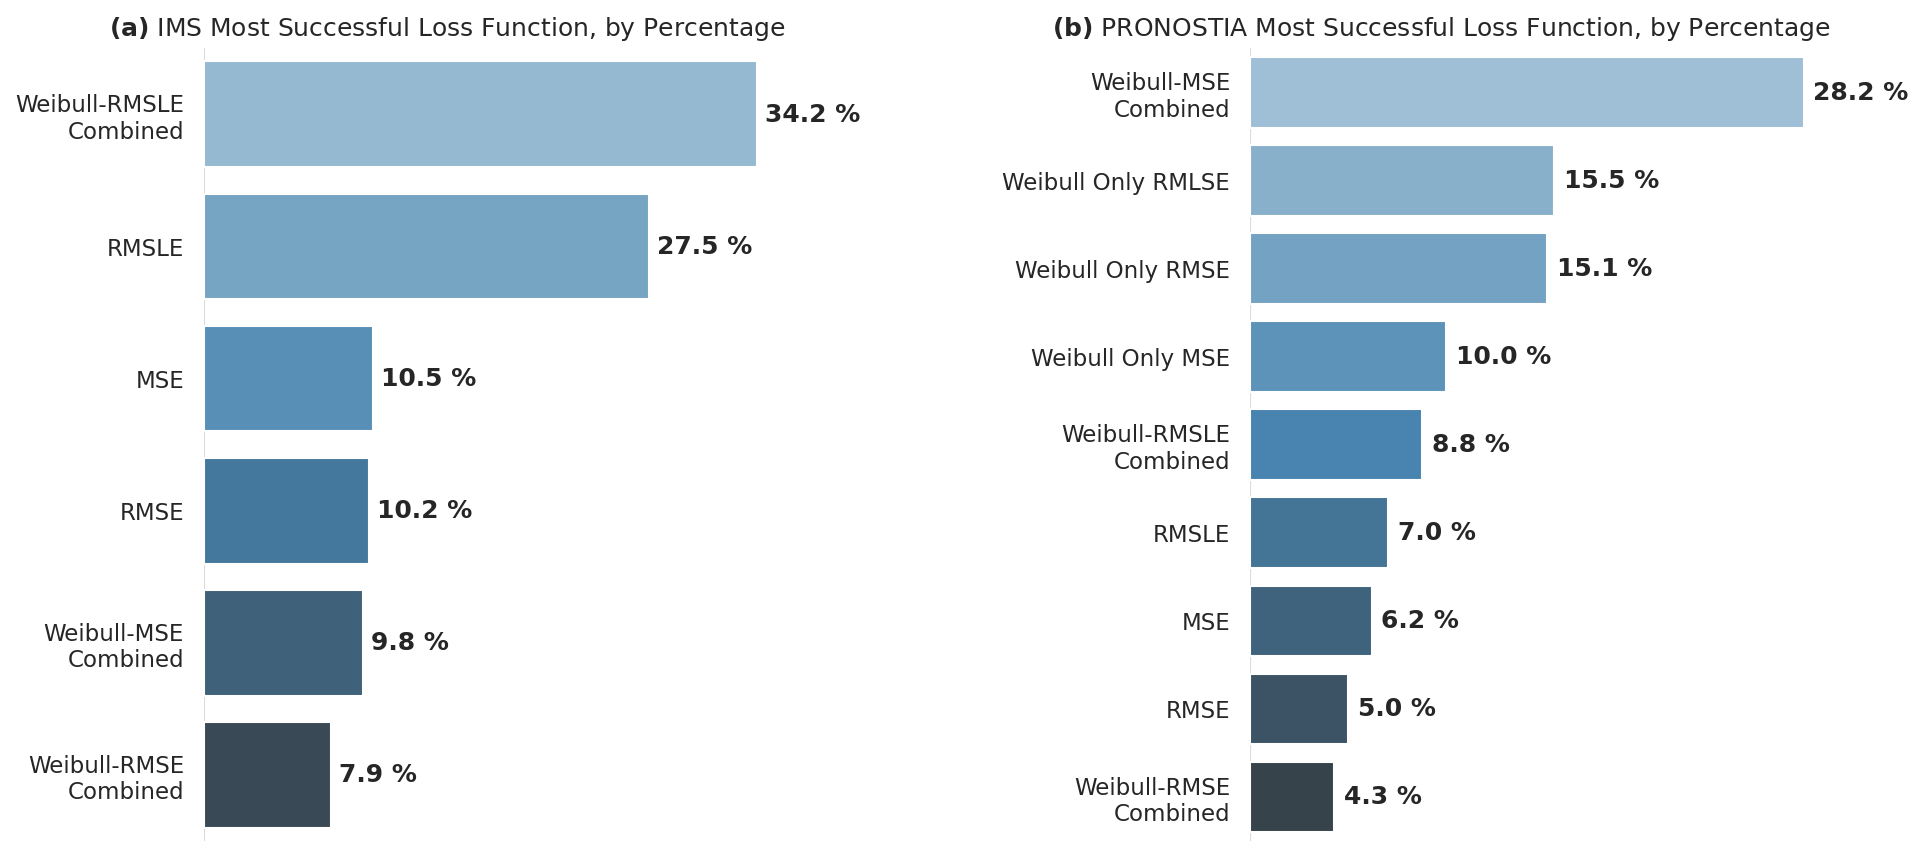

In [14]:
# sns.set(font_scale=1.0, style="whitegrid", font="DejaVu Sans")

loss_function_percentage_fig(
    path_results / "ims_count_results.csv",
    path_results / "femto_count_results.csv",
    dpi=150,
    save_plot=False
)

In [20]:
from src.visualization.visualize_results import loss_function_correlation_fig

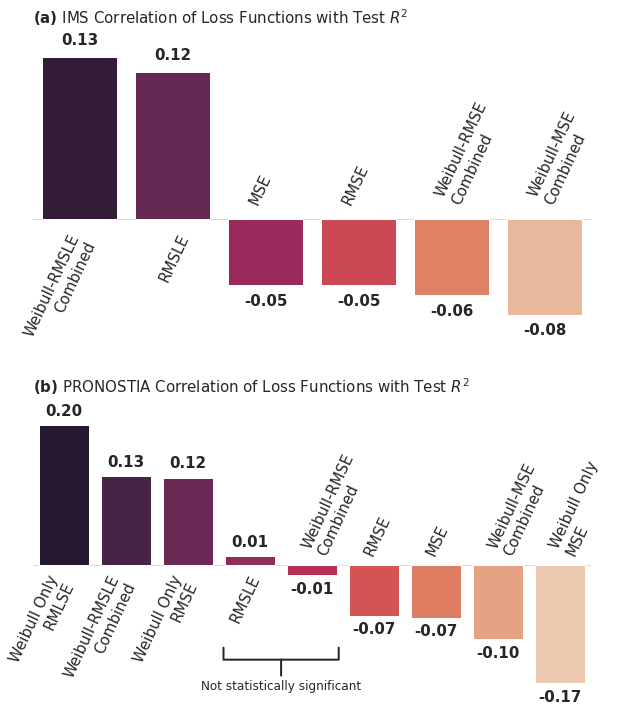

In [25]:
loss_function_correlation_fig(
    path_results / "ims_correlation_results.csv",
    path_results / "femto_correlation_results.csv",
    dpi=300,
    save_plot=False
)